# How I made my models and tested their accuracy

In [233]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json, string

from helper_functions import movies_matrix, vectorize, htmltostring, print_top_words
from helper_functions import plot_confusion_matrix, standard_confusion_matrix, sampling
from profit_curve import smote, oversample, undersample
from roc_curve import roc_curve
from clean_df import cleaned_data

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

import warnings
warnings.filterwarnings('ignore')

## Loading data
After collecting data using Goodreads API, load the json file and turn it into a pandas dataframe.

In [2]:
with open('goodreads_data2') as f:
    data2 = [json.loads(line) for line in f]
    
with open('goodreads_data3') as f:
    data3 = [json.loads(line) for line in f]

with open('goodreads_data4') as f:
    data4 = [json.loads(line) for line in f]
    
with open('goodreads_data5') as f:
    data5 = [json.loads(line) for line in f]

with open('goodreads_data6') as f:
    data6 = [json.loads(line) for line in f]

df = pd.DataFrame(data2+data3+data4+data5+data6)
new_df = df.drop_duplicates(subset=['author','title'],keep='first')

clean_data = cleaned_data(new_df)

## Exploratory Data Analysis - Out of Box

As this is imbalanced class, analysis has to rely on other performance metrics such as precision and recall. First, take a look at Logistic Regression, RandomForest, and GradientBoosting.

Consider the following:
- True Positive: Have Movie/Have Movie
- False Positive: Have Movie/Doesn't Have Movie
- False Negative: Doesn't Have Movie/Have Movie
- True Negative: Doesn't Have Movie/Doesn't Have Movie

I care about maximizing True Positives and minimizing False Negatives as I do not want to incorrectly identify the books that have movies as not having movies. The most interesting case is False Positives as these books are possibly identified to have a movie, but sometime in the future.

Therefore, my goal is to increase recall as high as possible.

In [3]:
X = clean_data.drop(['has_movie','year'],axis=1)
y = clean_data['has_movie']

Accuracy: 0.9401111708804016
Precision: 0.43243243243243246
Recall: 0.0486322188449848
F1 Score: 0.08743169398907104
ROC AUC Score: 0.5223153472273704


Confusion matrix, without normalization
[[  16   21]
 [ 313 5227]]


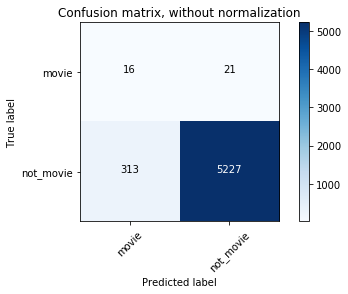

In [4]:
#Logistic Regression
log = LogisticRegression()
movies_matrix(log,X,y)

The beta coefficients provides the change in odds ratio.

In [5]:
# Look at beta coefficients
for name, coef in zip(list(X.columns),log.coef_[0]):
    print("{}: {}".format(name,coef))

death_date: 0.7782118778264577
female: -0.024302739792228533
male: 0.2549053059658449
is_series: -0.1890965666046758
biography: -0.4804893095068518
autobiography: -0.14267259073001481
science_fiction: 0.0856400562330393
romance: 0.05790993506646556
is_classic: 1.3893432380902222
comedy: 0.08505692893829496
coming-of-age: 0.4492376737364658
fantasy_fiction: -0.2941383400066981
mystery_fiction: -0.0040168047334527964
dystopian_future: 0.533269171766145
historical_fiction: 0.36092109211274764
realistic-fiction: 0.6260963734488044
drama: 0.6407023988433708
horror: 0.281389423958994
crime: 0.22125078432785372
suspense: 0.33509981430238234
paranormal: 0.2120283098343645
thriller: 0.4448521042259257
war: 0.10672114631189467
contemporary: 0.3796995813399712
chick-lit: -0.009912333240311252
action: 0.06567989514827134
young_adult: 0.2673034703662862
adult: 0.3437276726463518
animals: 0.4578550602003174
action: 0.06567989514827134
childrens_fiction: 0.1453418212358053
avg_rating: 0.2985731007816

Accuracy: 0.942442173211404
Precision: 0.4520547945205479
Recall: 0.10509554140127389
F1 Score: 0.17054263565891473
ROC AUC Score: 0.5487476566972169


Confusion matrix, without normalization
[[  33   40]
 [ 281 5223]]


Text(0,0.5,'Features')

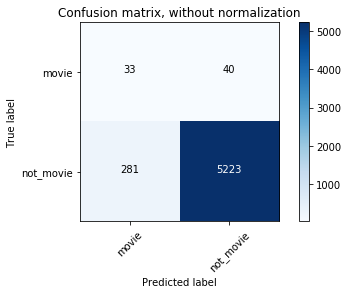

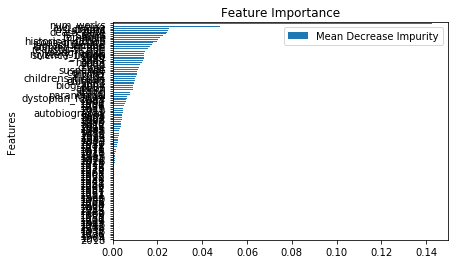

In [6]:
rfc = RandomForestClassifier()
movies_matrix(rfc,X,y)
feat_scores = pd.DataFrame({'Mean Decrease Impurity': rfc.feature_importances_},
                          index=X.columns)
feat_scores = feat_scores.sort_values(by='Mean Decrease Impurity')
feat_scores.plot(kind='barh', title='Feature Importance')
plt.ylabel('Features')

Accuracy: 0.9381387842926304
Precision: 0.5238095238095238
Recall: 0.031791907514450865
F1 Score: 0.05994550408719346
ROC AUC Score: 0.5149401135737042


Confusion matrix, without normalization
[[  11   10]
 [ 335 5221]]


Text(0,0.5,'Features')

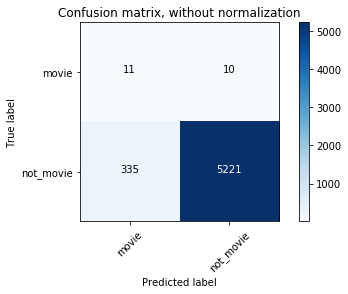

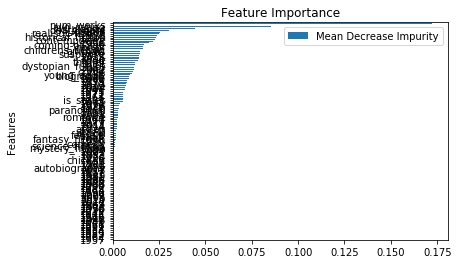

In [7]:
gbc = GradientBoostingClassifier()
movies_matrix(gbc,X,y)

feat_scores = pd.DataFrame({'Mean Decrease Impurity': gbc.feature_importances_},
                          index=X.columns)
feat_scores = feat_scores.sort_values(by='Mean Decrease Impurity')
feat_scores.plot(kind='barh',title='Feature Importance')
plt.ylabel('Features')

# Exploratory Data Analysis - Hyperparameter Tuning

I will use sklearn's GridSearchCV to tune the hyperparameters of my model(s). My goal is to see if my recall improves.

In [8]:
#Logisitc Regression Classifier
param_grid = {'class_weight':[None,'balanced'],
             'C':[0.001,0.01,0.1,1.0,1.1]}
lr = LogisticRegression()
cv_lr = GridSearchCV(estimator=lr,param_grid=param_grid,cv=5)
cv_lr.fit(X,y)
print(cv_lr.best_params_)

{'C': 1.1, 'class_weight': None}


While class_weight was returned None, the documentation suggested to use "balanced" when you have an imbalanced class.

Accuracy: 0.7518379056840595
Precision: 0.17302798982188294
Recall: 0.7640449438202247
F1 Score: 0.2821576763485477
ROC AUC Score: 0.7575252491558508


Confusion matrix, without normalization
[[ 272 1300]
 [  84 3921]]


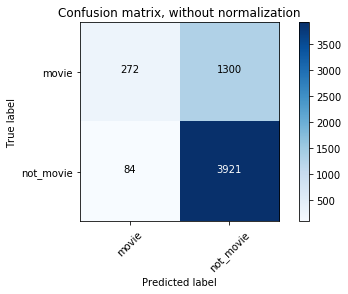

In [9]:
X = clean_data.drop(['has_movie','year'],axis=1)
y = clean_data['has_movie']

#Logistic Regression
log = LogisticRegression(C=1.0,class_weight='balanced')
movies_matrix(log,X,y)

In [10]:
param_grid = {'max_features': ['auto','sqrt','log2'],
             'class_weight': [None,'balanced']}
rfc = RandomForestClassifier()
cv_rfc = GridSearchCV(rfc,param_grid=param_grid,cv=5)
cv_rfc.fit(X,y)
print(cv_rfc.best_params_)

{'class_weight': 'balanced', 'max_features': 'sqrt'}


Accuracy: 0.9393939393939394
Precision: 0.4479166666666667
Recall: 0.13109756097560976
F1 Score: 0.20283018867924527
ROC AUC Score: 0.5605001998057703


Confusion matrix, without normalization
[[  43   53]
 [ 285 5196]]


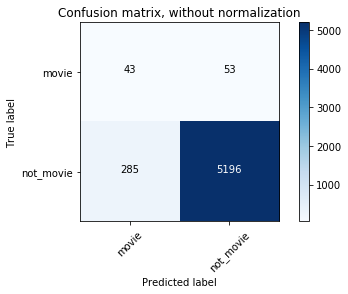

In [11]:
rfc = RandomForestClassifier(class_weight='balanced')
movies_matrix(rfc,X,y)

In [12]:
param_grid = {'loss' : ['deviance', 'exponential'],
             'max_features': ['auto','sqrt','log2']}
gbc = GradientBoostingClassifier()
cv_gb = GridSearchCV(gbc,param_grid=param_grid,cv=5)
cv_gb.fit(X,y)
print(cv_gb.best_params_)

{'loss': 'deviance', 'max_features': 'auto'}


Accuracy: 0.9395732472655549
Precision: 0.3333333333333333
Recall: 0.005970149253731343
F1 Score: 0.011730205278592375
ROC AUC Score: 0.5026035408611275


Confusion matrix, without normalization
[[   2    4]
 [ 333 5238]]


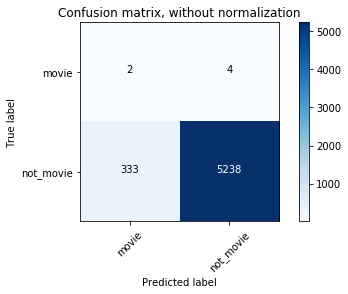

In [13]:
gbc = GradientBoostingClassifier(loss='exponential',max_features='sqrt')
movies_matrix(gbc,X,y)

The best performing model so far is Logisitic Regression with the highest recall score.

Accuracy: 0.730679576833423
Precision: 0.15324985092426952
Recall: 0.7581120943952803
F1 Score: 0.25496031746031744
ROC AUC Score: 0.7435081281445663


Confusion matrix, without normalization
[[ 257 1420]
 [  82 3818]]


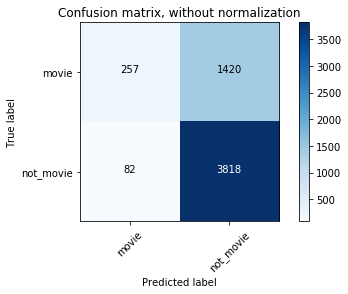

In [14]:
years = pd.get_dummies(clean_data.year)
years_columns = list(years.columns)
X = clean_data.drop(['has_movie','year','avg_rating','num_works']+years_columns,axis=1)
y = clean_data['has_movie']

#Logistic Regression
log = LogisticRegression(C=1.0,class_weight='balanced')
movies_matrix(log,X,y)

In [15]:
# Look at beta coefficients
for name, coef in zip(list(X.columns),log.coef_[0]):
    print("{}: {}".format(name,coef))

death_date: 0.6942623620972033
female: 0.2969219361585728
male: 0.7208768139954796
is_series: -0.3766294928254301
biography: -0.39392267034623624
autobiography: -0.25429560505765586
science_fiction: 0.03892336432064858
romance: -0.03406211823127641
is_classic: 1.4354099780463996
comedy: 0.24849848631380805
coming-of-age: 0.49533263611408174
fantasy_fiction: -0.06621002711925547
mystery_fiction: -0.04643800264264901
dystopian_future: 0.3039541996301308
historical_fiction: 0.29401470600469176
realistic-fiction: 0.5714446880718291
drama: 0.6297600418332447
horror: 0.15023971335456182
crime: 0.09886839039797131
suspense: 0.5175465218354628
paranormal: 0.21859446434702398
thriller: 0.6161638362526619
war: 0.09818984443044815
contemporary: 0.5619616003124566
chick-lit: -0.10362970583328523
action: 0.034542366677031734
young_adult: 0.4212454296323554
adult: 0.1446641474216077
animals: 0.32554750595439813
action: 0.034542366677031734
childrens_fiction: 0.10222497677575089


While our metrics returned promising results, there are features we have not explored--one being the text. I will now take a dive into NLP on the description of the books.

# Use WordVectorizer on description of books

In [226]:
def tokenize_wordnet(doc):
    '''
    INPUT: string
    OUTPUT: list of strings
    Tokenize and stem/lemmatize the document.
    '''
    wordnet = WordNetLemmatizer()
    return [wordnet.lemmatize(word) for word in word_tokenize(doc)]

def update_desc(descriptions):
    '''
    INPUT: list of documents
    OUTPUT: list of cleaned document
    '''
    update_desc = []
    for each in descriptions:
        tokens = [w.lower() for w in word_tokenize(each)] #split int words and convert to lowercase
        table = str.maketrans('', '', string.punctuation)
        stripped = [w.translate(table) for w in tokens] # remove punctuation from each word
        words = [word for word in stripped if word.isalpha()] # remove remaining tokens that are not alphabetic
        update_desc.append(' '.join(words))
    return update_desc

In [17]:
descriptions = htmltostring(new_df,'description')
update_desc = update_desc(descriptions)
vect = TfidfVectorizer(stop_words='english',max_df=0.95, 
                       min_df=2,max_features=1000,tokenizer=tokenize_wordnet)
desc_vect = vect.fit_transform(update_desc)
tfidf_feature_names = vect.get_feature_names()
nmf = NMF(n_components=10, random_state=1, alpha=.1, l1_ratio=.5).fit(desc_vect)
print_top_words(nmf, tfidf_feature_names, 20)

Topic #0: love life woman family story young mother child novel daughter father man home marriage girl year heart wife beautiful ha
Topic #1: la y el en que una los del su se e por al o di ha da era son il
Topic #2: und der die den zu da ist ein von sie sich mit eine auf er dem al e hat au
Topic #3: book story work reader edition classic american novel history s writer published tale author collection written u world modern writing
Topic #4: wa d knew did man year came wanted death took thought born said time murder later went met began woman
Topic #5: s murder ha killer case father death t mystery man friend detective crime dead turn town body just police sister
Topic #6: le et la à dans qui une du il ce est en au que son se plus l roman d
Topic #7: world ha war power human dark force secret magic evil king battle enemy earth ancient man land powerful year mysterious
Topic #8: nt know doe want just thing like ca ha friend make school girl way life need ll t think did
Topic #9: new yor

In [33]:
from sklearn.naive_bayes import MultinomialNB

new_df.has_movie.value_counts()

0    21237
1     1398
Name: has_movie, dtype: int64

In [36]:
x_train, x_test, y_train, y_test = train_test_split(desc_vect,new_df['has_movie'].values)

clf = MultinomialNB().fit(x_train,y_train)
y_pred = clf.predict(x_test)
np.mean(y_pred == y_test)

0.934264004241032

Accuracy: 0.9392118748895565
Precision: nan
Recall: 0.0
F1 Score: nan
ROC AUC Score: 0.5


Confusion matrix, without normalization
[[   0    0]
 [ 344 5315]]


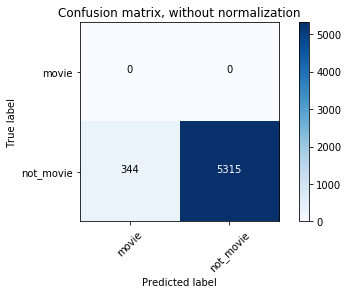

In [30]:
outcomes = standard_confusion_matrix(y_test,y_pred).ravel() #np.array([[tp, fp], [fn, tn]])
tp, fp, fn, tn = outcomes[0], outcomes[1], outcomes[2], outcomes[3]
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * precision * recall / (precision + recall)
print("Accuracy: {}".format(clf.score(x_test,y_test))) #Print accuracy score
print("Precision: {}".format(precision))
print("Recall: {}".format(recall))
print("F1 Score: {}".format(f1_score))
print("ROC AUC Score: {}".format(roc_auc_score(y_test,y_pred)))
print("\n")
#Make confusion matrix
plot_confusion_matrix(standard_confusion_matrix(y_test,y_pred),classes=['movie','not_movie'],title='Confusion matrix, without normalization')

To counteract the negative effects class imbalance can cause on my models, I will use sampling methods -- undersampling and oversampling.

In [47]:
desc_df = pd.DataFrame(desc_vect.todense())
desc_df['has_movie'] = new_df['has_movie'].values
upsampled, downsampled = sampling(desc_df,'has_movie',21237,1398)

Accuracy: 0.7311422921179018
Precision: 0.7074978938500421
Recall: 0.7895825498307635
F1 Score: 0.7462898782546877
ROC AUC Score: 0.7310485848569022


Confusion matrix, without normalization
[[4199 1736]
 [1119 3565]]


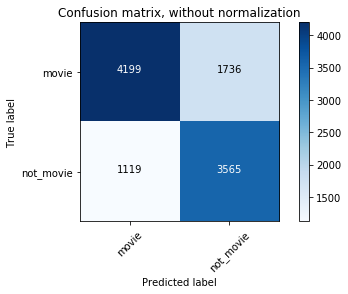

In [48]:
x = upsampled.drop(['has_movie'],axis=1)
y = upsampled['has_movie']
x_train, x_test, y_train, y_test = train_test_split(x,y)

clf = MultinomialNB().fit(x_train,y_train)
y_pred = clf.predict(x_test)
outcomes = standard_confusion_matrix(y_test,y_pred).ravel() #np.array([[tp, fp], [fn, tn]])
tp, fp, fn, tn = outcomes[0], outcomes[1], outcomes[2], outcomes[3]
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * precision * recall / (precision + recall)
print("Accuracy: {}".format(clf.score(x_test,y_test))) #Print accuracy score
print("Precision: {}".format(precision))
print("Recall: {}".format(recall))
print("F1 Score: {}".format(f1_score))
print("ROC AUC Score: {}".format(roc_auc_score(y_test,y_pred)))
print("\n")
#Make confusion matrix
plot_confusion_matrix(standard_confusion_matrix(y_test,y_pred),classes=['movie','not_movie'],title='Confusion matrix, without normalization')

Accuracy: 0.6394849785407726
Precision: 0.600896860986547
Recall: 0.783625730994152
F1 Score: 0.6802030456852791
ROC AUC Score: 0.6425131456091209


Confusion matrix, without normalization
[[268 178]
 [ 74 179]]


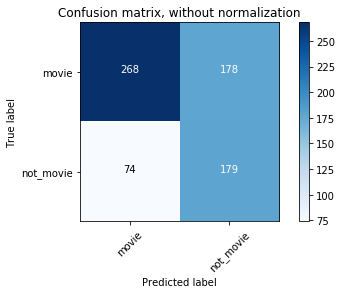

In [49]:
x = downsampled.drop(['has_movie'],axis=1)
y = downsampled['has_movie']
x_train, x_test, y_train, y_test = train_test_split(x,y)

clf = MultinomialNB().fit(x_train,y_train)
y_pred = clf.predict(x_test)
outcomes = standard_confusion_matrix(y_test,y_pred).ravel() #np.array([[tp, fp], [fn, tn]])
tp, fp, fn, tn = outcomes[0], outcomes[1], outcomes[2], outcomes[3]
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * precision * recall / (precision + recall)
print("Accuracy: {}".format(clf.score(x_test,y_test))) #Print accuracy score
print("Precision: {}".format(precision))
print("Recall: {}".format(recall))
print("F1 Score: {}".format(f1_score))
print("ROC AUC Score: {}".format(roc_auc_score(y_test,y_pred)))
print("\n")
#Make confusion matrix
plot_confusion_matrix(standard_confusion_matrix(y_test,y_pred),classes=['movie','not_movie'],title='Confusion matrix, without normalization')

The recall score is slightly higher than using Logistic Regression. This supports the idea that content of the book is important. Let's see what the predictions are on the whole dataset using the model trained on the upsampled dataset.

In [234]:
df = pd.DataFrame(data2+data3+data4+data5+data6)
new_df = df.drop_duplicates(subset=['author','title'],keep='first')
clean_df = cleaned_data(new_df)

In [235]:
clean_df.has_movie.value_counts()

0    21235
1     1400
Name: has_movie, dtype: int64

Accuracy: 0.15666003976143142
Precision: 0.055485751620847366
Recall: 0.7885714285714286
F1 Score: 0.10367657416537542
ROC AUC Score: 0.451785125634902


Confusion matrix, without normalization
[[ 1104 18793]
 [  296  2442]]


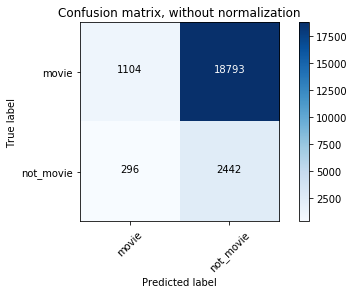

In [236]:
descriptions = htmltostring(new_df,'description')
updatedesc = update_desc(descriptions)
vect = TfidfVectorizer(stop_words='english',max_df=0.95, 
                       min_df=2,max_features=1000,tokenizer=tokenize_wordnet)
desc_vect = vect.fit_transform(updatedesc)
desc_df = pd.DataFrame(desc_vect.todense())

merged_df = pd.merge(clean_df,desc_df,left_index=True,right_index=True)

upsampled, downsampled = sampling(merged_df,'has_movie',21235,1400)
x_train = upsampled.drop(['has_movie'],axis=1).values
y_train = upsampled['has_movie'].values
x_test = merged_df.drop(['has_movie'],axis=1).values
y_test = merged_df['has_movie'].values

clf = MultinomialNB().fit(x_train,y_train)
y_pred = clf.predict(x_test)
outcomes = standard_confusion_matrix(y_test,y_pred).ravel() #np.array([[tp, fp], [fn, tn]])
tp, fp, fn, tn = outcomes[0], outcomes[1], outcomes[2], outcomes[3]
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * precision * recall / (precision + recall)
print("Accuracy: {}".format(clf.score(x_test,y_test))) #Print accuracy score
print("Precision: {}".format(precision))
print("Recall: {}".format(recall))
print("F1 Score: {}".format(f1_score))
print("ROC AUC Score: {}".format(roc_auc_score(y_test,y_pred)))
print("\n")
#Make confusion matrix
plot_confusion_matrix(standard_confusion_matrix(y_test,y_pred),classes=['movie','not_movie'],title='Confusion matrix, without normalization')

Accuracy: 0.15666003976143142
Precision: 0.2556016597510373
Recall: 0.88
F1 Score: 0.39614147909967845
ROC AUC Score: 0.8555168354132329


Confusion matrix, without normalization
[[ 1232  3588]
 [  168 17647]]


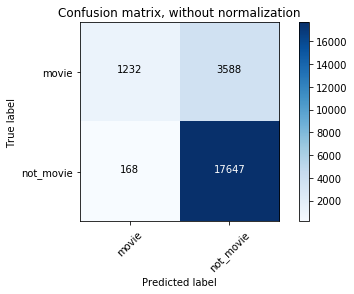

In [238]:
log = LogisticRegression(C=1.0,class_weight='balanced').fit(x_train,y_train)
y_pred = log.predict(x_test)
outcomes = standard_confusion_matrix(y_test,y_pred).ravel() #np.array([[tp, fp], [fn, tn]])
tp, fp, fn, tn = outcomes[0], outcomes[1], outcomes[2], outcomes[3]
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * precision * recall / (precision + recall)
print("Accuracy: {}".format(clf.score(x_test,y_test))) #Print accuracy score
print("Precision: {}".format(precision))
print("Recall: {}".format(recall))
print("F1 Score: {}".format(f1_score))
print("ROC AUC Score: {}".format(roc_auc_score(y_test,y_pred)))
print("\n")
#Make confusion matrix
plot_confusion_matrix(standard_confusion_matrix(y_test,y_pred),classes=['movie','not_movie'],title='Confusion matrix, without normalization')

In [241]:
all_pred = log.predict_proba(x_test)[:,1]

In [251]:
new_df['predictions'] = all_pred
new_df

,author,avg_rating,birth_date,book_id,death_date,description,gender,hometown,image_url,is_series,...,month,num_works,pages,rating_dist,tags,title,widget,year,has_movie,predictions
0,Suzanne Collins,4.34,1962/08/11,2767052,None,<b>Winning will make you famous. <br />Losing ...,female,"Hartford, Connecticut",https://images.gr-assets.com/books/1447303603m...,"{'series_work': {'id': '339872', 'user_positio...",...,14.0,26.0,374.0,5:2893853|4:1597247|3:611025|2:140138|1:73613|...,"[to-read, favorites, currently-reading, young-...","The Hunger Games (The Hunger Games, #1)",<style>\n #goodreads-widget {\n font-famil...,2008.0,1,0.753093
1,J.K. Rowling,4.45,1965/07/31,3,None,Harry Potter's life is miserable. His parents ...,female,"Yate, South Gloucestershire, England",https://images.gr-assets.com/books/1474154022m...,"{'series_work': {'id': '167817', 'user_positio...",...,26.0,177.0,320.0,5:3368308|4:1256094|3:487140|2:109717|1:84179|...,"[currently-reading, favorites, fantasy, young-...",Harry Potter and the Sorcerer's Stone (Harry P...,<style>\n #goodreads-widget {\n font-famil...,1997.0,1,0.771151
2,Stephenie Meyer,3.58,1973/12/24,41865,None,<b>About three things I was absolutely positiv...,female,Connecticut,https://images.gr-assets.com/books/1361039443m...,"{'series_work': {'id': '165622', 'user_positio...",...,6.0,64.0,498.0,5:1441103|4:926580|3:841147|2:461571|1:479124|...,"[to-read, young-adult, fantasy, favorites, vam...","Twilight (Twilight, #1)",<style>\n #goodreads-widget {\n font-famil...,2006.0,1,0.413599
3,Harper Lee,4.26,1926/04/28,2657,2016/02/19,The unforgettable novel of a childhood in a sl...,female,"Monroeville, Alabama",https://images.gr-assets.com/books/1361975680m...,"{'series_work': {'id': '735877', 'user_positio...",...,23.0,44.0,324.0,5:1842275|4:1068451|3:471751|2:123782|1:63791|...,"[to-read, currently-reading, classics, favorit...",To Kill a Mockingbird,<style>\n #goodreads-widget {\n font-famil...,2006.0,1,0.997591
4,F. Scott Fitzgerald,3.90,1896/09/24,4671,1940/12/21,"Here is a novel, glamorous, ironical, compassi...",male,"St. Paul, Minnesota",https://images.gr-assets.com/books/1490528560m...,None,...,NaN,662.0,180.0,5:1047704|4:1015555|3:651952|2:210508|1:92756|...,"[to-read, classics, currently-reading, favorit...",The Great Gatsby,<style>\n #goodreads-widget {\n font-famil...,2004.0,1,0.980348
5,John Green,4.25,None,11870085,None,<i>Librarian note: an alternate cover for this...,None,Indianapolis,https://images.gr-assets.com/books/1360206420m...,None,...,10.0,45.0,313.0,5:1432181|4:775670|3:369625|2:105786|1:55252|t...,"[currently-reading, to-read, favorites, young-...",The Fault in Our Stars,<style>\n #goodreads-widget {\n font-famil...,2012.0,1,0.788733
6,J.R.R. Tolkien,4.25,1892/01/03,5907,1973/09/02,<i>In a hole in the ground there lived a hobbi...,male,"Bloemfontein, Mangaung, Free State",https://images.gr-assets.com/books/1372847500m...,"{'series_work': [{'id': '384360', 'user_positi...",...,15.0,349.0,366.0,5:1201816|4:706091|3:303653|2:80397|1:48162|to...,"[owned, adventure, young-adult, to-read, favou...",The Hobbit,<style>\n #goodreads-widget {\n font-famil...,2002.0,1,0.866565
7,J.D. Salinger,3.80,1919/01/01,5107,2010/01/27,The hero-narrator of <i>The Catcher in the Rye...,male,"Manhattan, New York",https://images.gr-assets.com/books/1398034300m...,None,...,30.0,95.0,277.0,5:764201|4:703687|3:483118|2:196709|1:116060|t...,"[classics, favorites, fiction, to-read, classi...",The Catcher in the Rye,<style>\n #goodreads-widget {\n font-famil...,2001.0,0,0.993724
8,Jane Austen,4.25,1775/12/16,1885,1817/07/18,"'It is a truth universally acknowledged, that ...",female,"Steventon Rectory, Hampshire, England",https://images.gr-assets.com/books/1320399351m...,None,...,10.0,1305.0,279.0,5:1243925|4:650097|3:301912|2:91776|1:58683|to...,"[favorites, fiction, classic, to-read, books-i...",Pride and Prejudice,<style>\n #goodreads-widget {\n font-famil...,2000.0,1,0.977555
9,Khaled Hosseini,4.27,1965/0